# **IMPACT OF HURRICANE BRET (AUGUST 1999) ON VARIOUS TEXAS LOCATIONS**

Name: J Pilartes-Congo

Date: Feb 13, 2024

Purpose: Evaluate the various impacts of Hurricane Bret (August 17-25, 1999) on various Texas locations. The goal of the project is to assess how weather conditions changed as Bret approached the Gulf Coast, particularly Southern Texas.

Hurricane Bret made landfall on Padre Island in 19999 with peak wind intensities of 233 km/h (larger than Harvey and Hanna).

All information pertinent to this assignment is available on [this link](https://github.com/jpilartescongo/data-analytics)


# **Datasets**

Dates: August 1-31, 1999

Data Resolution: Daily

Texas Cities: Corpus Christi, Galveston, Houston, Port Arthur, San Antonio

.......................................................................................................................................................................

**Point Dataset:**
* Data source: NOAA Daily Summaries - [National Centers for Environmental Information](https://www.ncei.noaa.gov/cdo-web/datasets)
* Variables: lat, lon precipitation, percent of possible sunshine, average temperature, max temperature, min temperature, average wind speed.

**Precipitation:**
* Datasets: CPC Unified Gauge-Based Analysis of Daily Precipitation over CONUS - clipped to following bounding box: Lats (-100, -93) and Lon (25, 33) and 1-31 Aug 1991
* Data source: National Oceanic and Atmospheric Administration - [Physical Sciences Laboratory](https://psl.noaa.gov/data/gridded/data.unified.daily.conus.html)
** Format: netcdf4-classic with lat/lon added to file
** Variables: lat, lon, precipitation (daily accumulation), time

**Temperature:**
* Datasets: CPC Global Temperature (max and min) - clipped to following bounding box: Lats (-100, -93) and Lon (25, 33) and 1-31 Aug 1991
* Data source: National Oceanic and Atmospheric Administration - [Physical Sciences Laboratory](https://psl.noaa.gov/data/gridded/data.cpc.globaltemp.html)
* Format: netcdf4-classic with lat/lon added to file
* Variables: lat, lon, max/min temperature, time

# **Preparing the Environment**

In [84]:
# install supporting libraries/modules
!pip install netCDF4 xarray cartopy

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from os.path import join
from IPython.display import clear_output
import datetime as dt
import pandas as pd
import os
from IPython.display import Image
import imageio.v2 as imageio
from matplotlib import dates
import matplotlib.colors as mcolors
import seaborn as sns

# --------------------------------------------------------------
# reset main directory to any previous downloads from git repository
!rm -rf '/content/data-analytics'

# --------------------------------------------------------------
# clone git hub functions to support this assignment
!git clone https://github.com/jpilartescongo/data-analytics.git

# --------------------------------------------------------------
# access imported files
import sys
sys.path.append('/content/data-analytics')
import myFunction
# --------------------------------------------------------------
# clear output
clear_output()

# **General Reference Map of Locations of Interest**

Plotting coordinates and displaying general reference map of locations of interest:
* Corpus Christi International Airport
* Galveston Scholes Field International Airport
* Houston William P. Hobby Airport
* Port Arthur - Jack Brooks Regional Airport
* San Antonio International Airport


---



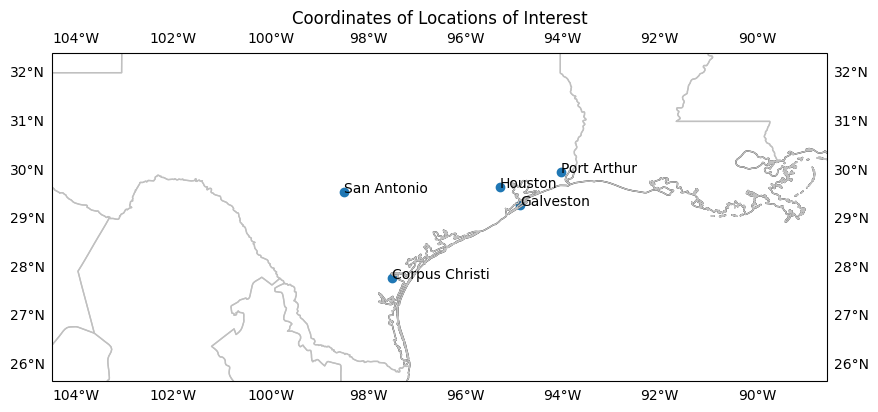

In [85]:
# coordinates for locations of interest:
coords = [(27.77335, -97.51302, 'Corpus Christi'), (29.27036, -94.86421, 'Galveston'), (29.64586, -95.28212, 'Houston'), (29.95205, -94.02616, 'Port Arthur'), (29.54429, -98.48395, 'San Antonio')]
myFunction.general_reference_map(coords)

# bounding boxes / city limits for each location
# https://boundingbox.klokantech.com/ used to help with accurate bounding box
cctx_min_lat, cctx_max_lat, cctx_min_lon, cctx_max_lon = 27.46, 27.87, -97.58, -97.12
gltx_min_lat, gltx_max_lat, gltx_min_lon, gltx_max_lon = 29.10, 29.41, -94.93, -94.68
htx_min_lat, htx_max_lat, htx_min_lon, htx_max_lon = 29.35, 30.08, -95.89, -30.08
patx_min_lat, patx_max_lat, patx_min_lon, patx_max_lon = 29.65, 30.02, -94.11, -93.72
satx_min_lat, satx_max_lat, satx_min_lon, satx_max_lon = 29.19, 29.61, -98.72, -98.32

Corpus Christi, Houston, Galveston, and Port Arthur were selected to evaluate the impact of Bret on coastal cities. San Antonio was selected to negate (or not) hurricane influence further in land.

# **Working with Gridded and Point Data (Precipitation, Temperature, and Other)**

In [86]:
# read nc4 files
precip_data = xr.open_mfdataset('/content/data-analytics/precip_aug_1999.nc4').to_dataframe().reset_index()
conus_precip_data = xr.open_mfdataset('/content/data-analytics/precip_1999_conus.nc4').to_dataframe().reset_index()
min_temp_data = xr.open_mfdataset('/content/data-analytics/tmin.1999.nc.nc4').to_dataframe().reset_index()
max_temp_data = xr.open_mfdataset('/content/data-analytics/tmax.1999.nc.nc4').to_dataframe().reset_index()

# read station data
station_data = pd.read_csv('/content/data-analytics/stations.csv')

# convert date column to datetime for easier interpretability and data handling
station_data['DATE'] = pd.to_datetime(station_data['DATE'])

**Plot Precipitation Events for Entire Month - August 1999: Contiguous U.S.**

In [87]:
# convert time column to datetime, select and store august events to a unique variable, group results based on time
conus_precip_data['time'] = pd.to_datetime(conus_precip_data['time'])
time_august = conus_precip_data[conus_precip_data['time'].dt.strftime('%Y-%m').str.startswith('1999-08')]
grouped_time_aug = time_august.groupby('time')

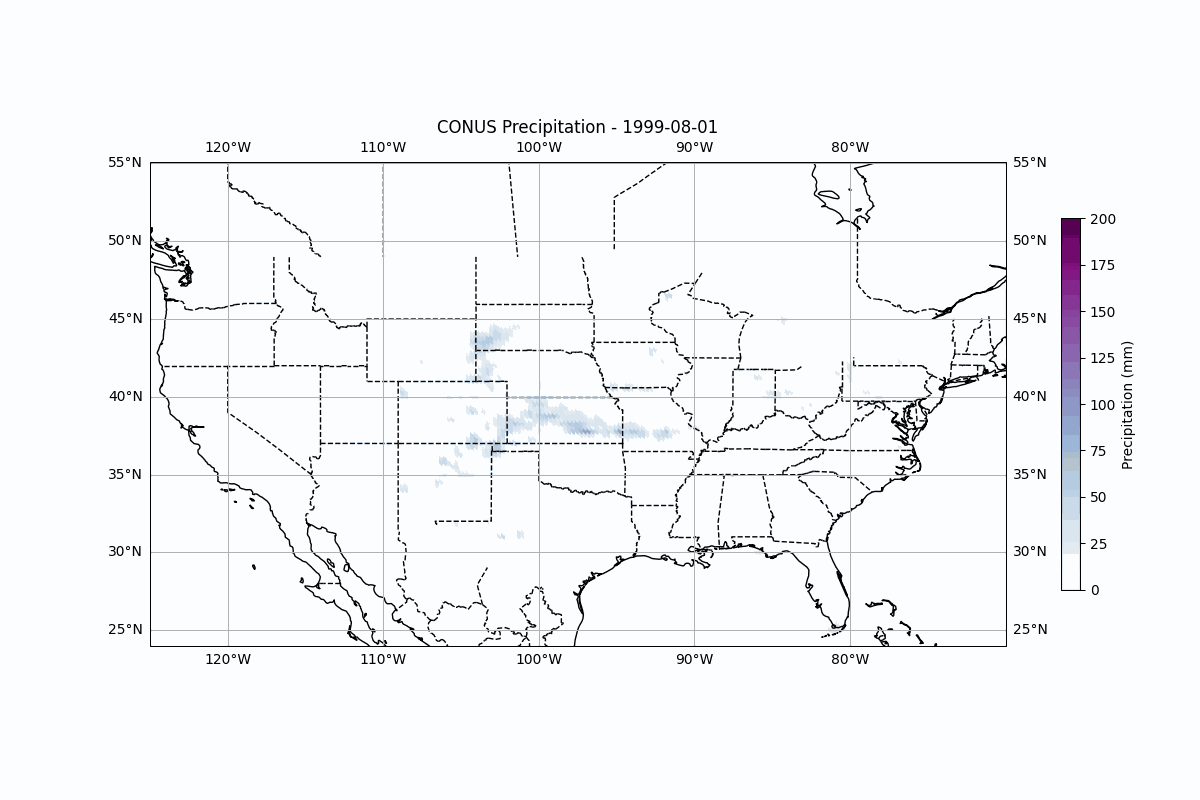

In [88]:
# use imageio to create a gif image with the precipitation amounts for the entire month of August
# original dataset has daily information for the entire year, hence a range has to be determined to include only the month of August

# loop to create a series of individual images with precipitation map
images = []

# state boundaries
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='10m', facecolor='none')

# iterate over each unique value of 'time'
for time, group_df in grouped_time_aug:
  # Extract lon, lat, and precip values for the current time period
  lon, lat, precip = group_df['lon'], group_df['lat'], group_df['precip']

  # create a figure and axis with the appropriate projection
  # plot the precipitation nd add coastlines/gridlines/statelines
  plt.figure(figsize=(12, 8))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.add_feature(states_provinces, edgecolor='black', linewidth=1, linestyle='dashed')

  scatter = ax.scatter(lon, lat, c=precip, cmap='BuPu', vmin=0, vmax=200)
  ax.coastlines()
  ax.gridlines(draw_labels=True)

  # add colorbar with a the appropriate legend
  sm = plt.cm.ScalarMappable(cmap='BuPu', norm=mcolors.Normalize(vmin=0, vmax=200))
  sm.set_array([])
  cbar = plt.colorbar(sm, ax=ax, label='Precipitation (mm)', pad=0.06, fraction=0.02)
  ax.set_extent([-125, -70, 24, 52])

  # save all figures for later usage in creating the gif
  plt.title(f'CONUS Precipitation - {time.strftime("%Y-%m-%d")}')
  filename = f'precipitation_day_{time.strftime("%Y-%m-%d")}.png'
  plt.savefig(filename)
  plt.close()
  images.append(filename)
  # break
  # clear output
  clear_output()

# create gif from temporary images, add loop functionality, then remove all images after gif has been created
imageio.mimsave('precipitation.gif', [imageio.imread(image) for image in images], duration=3000)
imageio.mimwrite('precipitation.gif', [imageio.imread(image) for image in images], loop=0)

for image in images:
  os.remove(image)

# display the resulting gif
Image('precipitation.gif')

**This gif shows precipitation events across the US in August 1999. Observe the peak occurence around August 22. This suggests that Bret had the highest impact on Corpus Christi and surrounding areas approximately 4-5 days after making landfall.**

In [89]:
# original precipitation data has lon values in degrees east, which is problematic for programming
# here we convert those lon values to typical west orientation
conus_precip_data['lon'] = ((conus_precip_data['lon'] + 180) % 360) - 180

Text(0.5, 1.0, 'Daily Accumulated Precipitation: CONUS 1999')

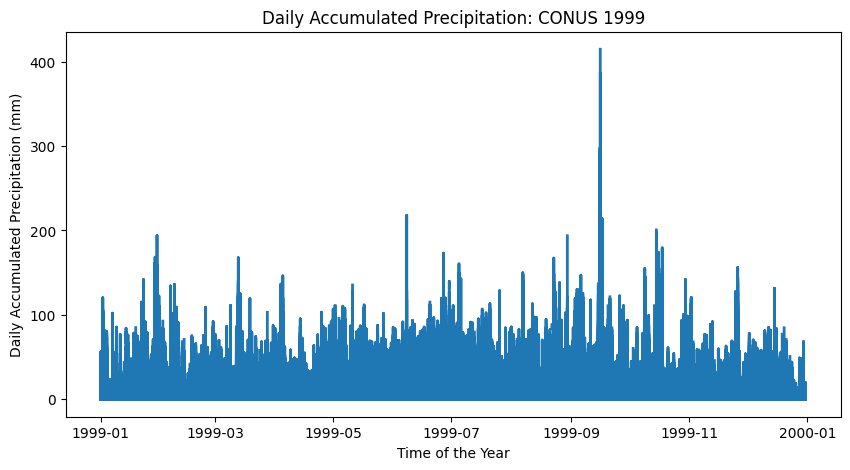

In [90]:
# print national precipitation for entire year
x_conus = conus_precip_data['time']
y_conus = conus_precip_data['precip']
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_conus, y_conus, linewidth=2.0)
plt.xlabel('Time of the Year')
plt.ylabel('Daily Accumulated Precipitation (mm)')
plt.title('Daily Accumulated Precipitation: CONUS 1999')

In [91]:
conus_precip_data

,lon,time,lat,precip
0,-129.875,1999-01-01,20.125,NaN
1,-129.875,1999-01-01,20.375,NaN
2,-129.875,1999-01-01,20.625,NaN
3,-129.875,1999-01-01,20.875,NaN
4,-129.875,1999-01-01,21.125,NaN
...,...,...,...,...
13139995,-55.125,1999-12-31,48.875,NaN
13139996,-55.125,1999-12-31,49.125,NaN
13139997,-55.125,1999-12-31,49.375,NaN
13139998,-55.125,1999-12-31,49.625,NaN


Now we focus on the study locations only: Corpus Christi, Galveston, Houston, Port Arthur, and San Antonio

In [92]:
# assign filtered attributes to particular attributes
locations = ['CORPUS CHRISTI', 'GALVESTON', 'HOUSTON', 'PORT ARTHUR', 'SAN ANTONIO']

# call individaul station function to assign variables
cctx_station, gltx_station = myFunction.indiv_station(station_data, locations[0]), myFunction.indiv_station(station_data, locations[1])
htx_station, patx_station = myFunction.indiv_station(station_data, locations[2]), myFunction.indiv_station(station_data, locations[3])
satx_station = myFunction.indiv_station(station_data, locations[4])

**Working with Point Weather Data**

In [93]:
station_data

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMIN,PEAK_SPEED,PEAK_DIR
0,USW00012924,"CORPUS CHRISTI INTERNATIONAL AIRPORT, TX US",27.77335,-97.51302,12.5,1999-08-22,9.8,",,X",115.8,",,0",25.6,",,W",27.8,23.3,10.28192,130.0
1,USW00012924,"CORPUS CHRISTI INTERNATIONAL AIRPORT, TX US",27.77335,-97.51302,12.5,1999-08-23,10.9,",,X",51.8,",,0",25.6,",,W",28.3,22.8,8.94080,100.0
2,USW00012924,"CORPUS CHRISTI INTERNATIONAL AIRPORT, TX US",27.77335,-97.51302,12.5,1999-08-24,5.2,",,X",5.3,",,0",27.2,",,W",31.1,23.3,8.04672,140.0
3,USW00012924,"CORPUS CHRISTI INTERNATIONAL AIRPORT, TX US",27.77335,-97.51302,12.5,1999-08-16,4.8,",,X",0.0,",,0",28.3,",,W",35.0,21.7,8.04672,90.0
4,USW00012924,"CORPUS CHRISTI INTERNATIONAL AIRPORT, TX US",27.77335,-97.51302,12.5,1999-08-25,2.8,",,X",0.0,",,0",28.3,",,W",31.7,25.0,9.38784,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,USW00012921,"SAN ANTONIO INTERNATIONAL AIRPORT, TX US",29.54429,-98.48395,243.6,1999-08-15,3.0,",,X",0.0,",,0,2400",31.1,",,W",38.3,23.3,8.94080,190.0
151,USW00012921,"SAN ANTONIO INTERNATIONAL AIRPORT, TX US",29.54429,-98.48395,243.6,1999-08-27,3.1,",,X",0.0,",,0,2400",31.1,",,W",36.7,25.0,7.15264,130.0
152,USW00012921,"SAN ANTONIO INTERNATIONAL AIRPORT, TX US",29.54429,-98.48395,243.6,1999-08-16,2.9,",,X",0.0,",,0,2400",31.7,",,W",37.8,25.0,18.32864,70.0
153,USW00012921,"SAN ANTONIO INTERNATIONAL AIRPORT, TX US",29.54429,-98.48395,243.6,1999-08-20,2.8,",,X",0.0,"T,,0,2400",31.7,",,W",39.4,23.9,7.59968,90.0


Text(0.5, 0.98, 'Relationship Between Peak Wind Speed and Its Direction for All Locations (August 1999)')

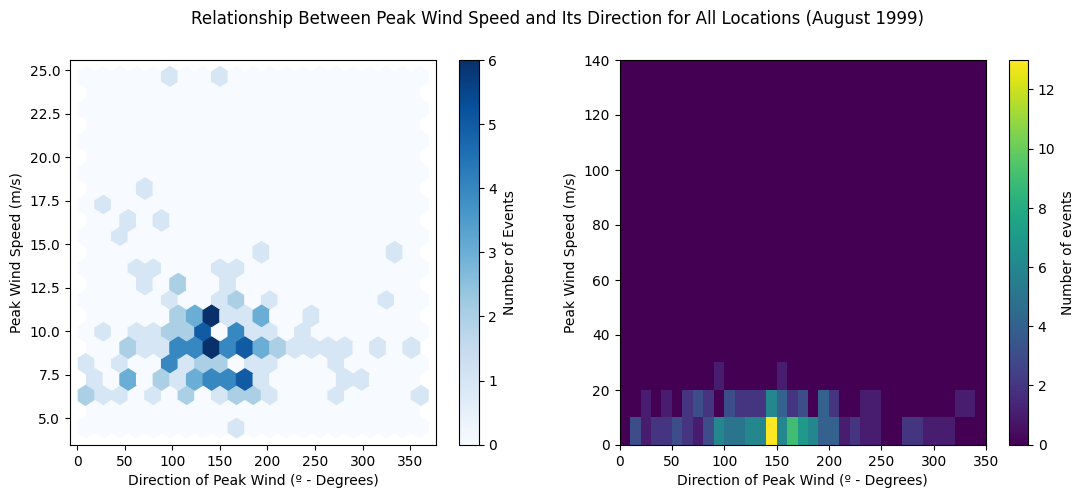

In [94]:
# hexbin and his2d plots based on peak wind speed and direction of peak wind speed
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
peak_info_x_label, peak_info_y_label = 'Direction of Peak Wind (º - Degrees)', 'Peak Wind Speed (m/s)'

# hexbin plot based on peak wind speed and direction of peak wind speed
x, y = station_data['PEAK_DIR'], station_data['PEAK_SPEED']
hexbin = axs[0].hexbin(x, y, gridsize=20, cmap='Blues')
cbar = plt.colorbar(hexbin, ax=axs[0], label='Number of Events')
axs[0].set_xlabel(peak_info_x_label)
axs[0].set_ylabel(peak_info_y_label)

# hist2d plot based on peak wind speed and direction of peak wind speed
hist=axs[1].hist2d(station_data['PEAK_DIR'], station_data['PEAK_SPEED'], bins=(np.arange(0, 360, 10), np.arange(0, 150, 10)))
axs[1].set_xlabel(peak_info_x_label)
axs[1].set_ylabel(peak_info_y_label)
cbar = plt.colorbar(hist[3], ax=axs[1], label='Number of events')

plt.suptitle('Relationship Between Peak Wind Speed and Its Direction for All Locations (August 1999)')

These figures suggest that the direction of peak winds was mostly between 130 and 180 degrees.

Text(0.5, 0.98, 'Relationship Between Peak Wind Speed and Its Direction for All Locations (August 1999)')

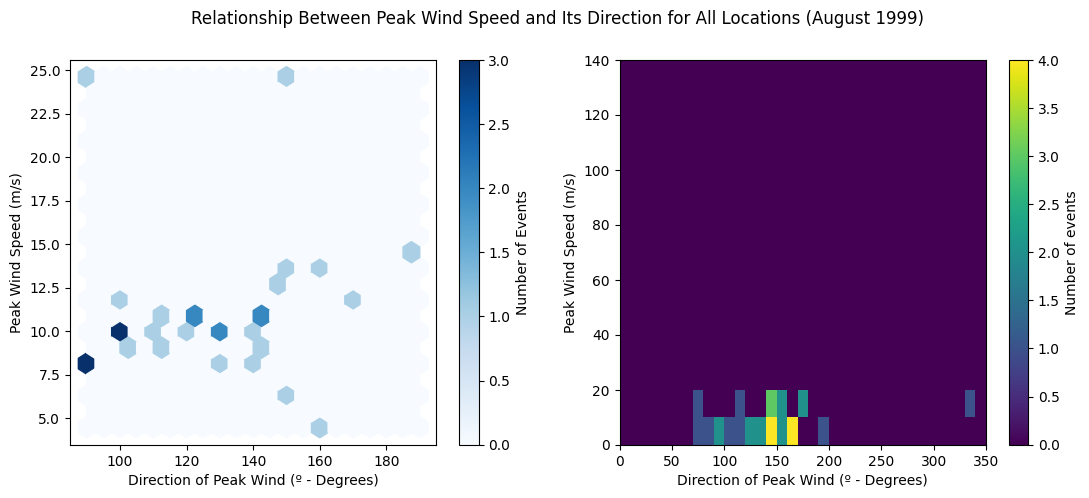

In [95]:
# hexbin and his2d plots based on peak wind speed and direction of peak wind speed
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
peak_info_x_label, peak_info_y_label = 'Direction of Peak Wind (º - Degrees)', 'Peak Wind Speed (m/s)'

# hexbin plot based on peak wind speed and direction of peak wind speed
x, y = cctx_station['PEAK_DIR'], cctx_station['PEAK_SPEED']
hexbin = axs[0].hexbin(x, y, gridsize=20, cmap='Blues')
cbar = plt.colorbar(hexbin, ax=axs[0], label='Number of Events')
axs[0].set_xlabel(peak_info_x_label)
axs[0].set_ylabel(peak_info_y_label)

# hist2d plot based on peak wind speed and direction of peak wind speed
hist=axs[1].hist2d(satx_station['PEAK_DIR'], satx_station['PEAK_SPEED'], bins=(np.arange(0, 360, 10), np.arange(0, 150, 10)))
axs[1].set_xlabel(peak_info_x_label)
axs[1].set_ylabel(peak_info_y_label)
cbar = plt.colorbar(hist[3], ax=axs[1], label='Number of events')

plt.suptitle('Relationship Between Peak Wind Speed and Its Direction for All Locations (August 1999)')

Text(0, 0.5, 'Number of Events')

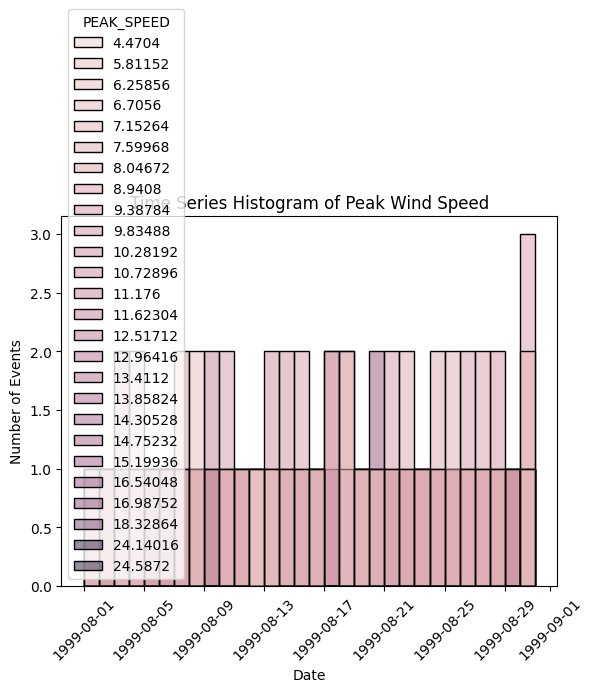

In [96]:
# create a time series histogram of the speak speed
sns.histplot(data=station_data, x="DATE", hue="PEAK_SPEED", bins=30)

# Set the title axis labels
plt.title("Time Series Histogram of Peak Wind Speed")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Number of Events")

In [97]:
stations = [cctx_station, gltx_station, htx_station, patx_station, satx_station]

max_precip = []
for station in stations:
  x = station['PRCP'].max()
  max_precip.append(x)

print(max_precip)

[115.8, 5.3, 12.4, 0.0, 26.2]


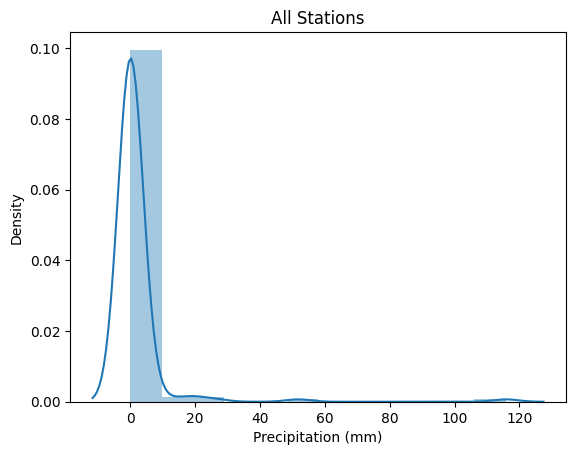

In [98]:
# data distribution plot of cctx_station
sns.distplot(station_data['PRCP'])
plt.xlabel('Precipitation (mm)')
plt.title('All Stations')
clear_output()
plt.show()

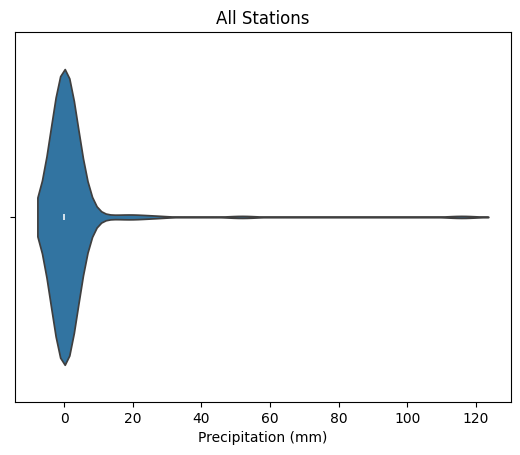

In [99]:
# violin diagram using for all stations
sns.violinplot(x=station_data['PRCP'])
plt.xlabel('Precipitation (mm)')
plt.title('All Stations')
clear_output()
plt.show()

These plots suggest skew distribution of the data.

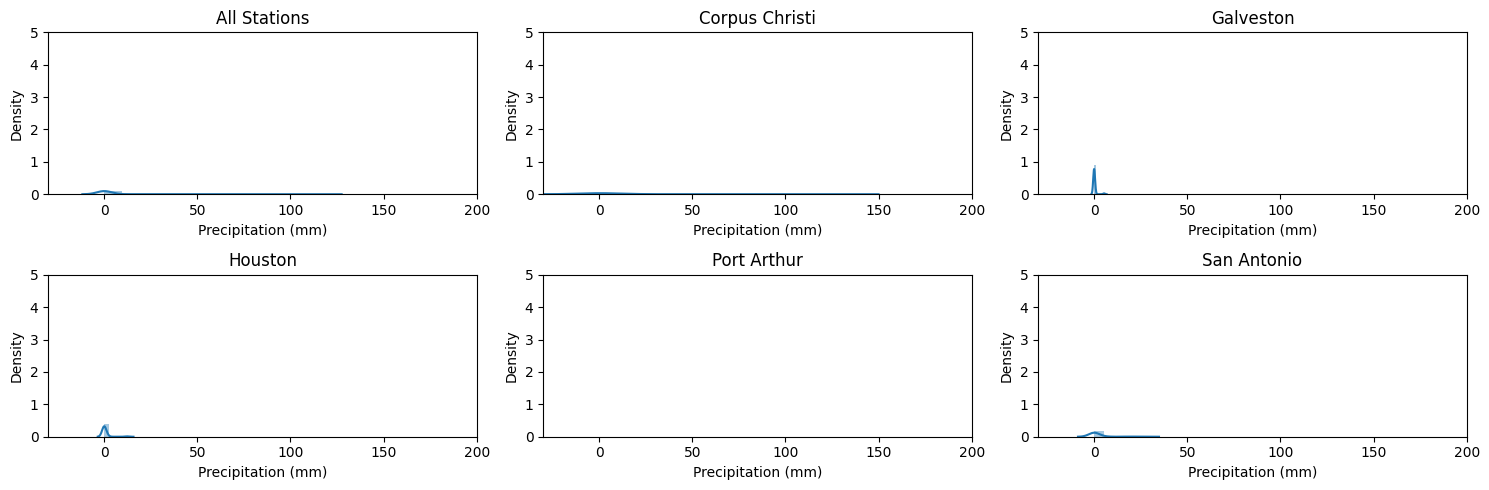

In [100]:
# density distribution plots
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
x_min, x_max, y_min, y_max = -30, 200, 0, 5

sns.distplot(station_data['PRCP'], ax=axes[0, 0])
axes[0, 0].set_xlabel('Precipitation (mm)')
axes[0, 0].set_title('All Stations')
axes[0, 0].set_xlim(x_min, x_max)
axes[0, 0].set_ylim(y_min, y_max)

sns.distplot(cctx_station['PRCP'], ax=axes[0, 1])
axes[0, 1].set_xlabel('Precipitation (mm)')
axes[0, 1].set_title('Corpus Christi')
axes[0, 1].set_xlim(x_min, x_max)
axes[0, 1].set_ylim(y_min, y_max)

sns.distplot(gltx_station['PRCP'], ax=axes[0, 2])
axes[0, 2].set_xlabel('Precipitation (mm)')
axes[0, 2].set_title('Galveston')
axes[0, 2].set_xlim(x_min, x_max)
axes[0, 2].set_ylim(y_min, y_max)

sns.distplot(htx_station['PRCP'], ax=axes[1, 0])
axes[1, 0].set_xlabel('Precipitation (mm)')
axes[1, 0].set_title('Houston')
axes[1, 0].set_xlim(x_min, x_max)
axes[1, 0].set_ylim(y_min, y_max)

sns.distplot(patx_station['PRCP'], ax=axes[1, 1])
axes[1, 1].set_xlabel('Precipitation (mm)')
axes[1, 1].set_title('Port Arthur')
axes[1, 1].set_xlim(x_min, x_max)
axes[1, 1].set_ylim(y_min, y_max)

sns.distplot(satx_station['PRCP'], ax=axes[1, 2])
axes[1, 2].set_xlabel('Precipitation (mm)')
axes[1, 2].set_title('San Antonio')
axes[1, 2].set_xlim(x_min, x_max)
axes[1, 2].set_ylim(y_min, y_max)

plt.tight_layout()
clear_output()
plt.show()

These plots also suggest skew distribution of the data. Port Arthur appears to have some data vacancy that will be reassed as this assignment goes on.

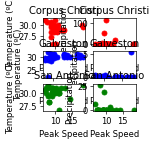

In [101]:
# create subplots
fig, axs = plt.subplots(3, 2, figsize=(2, 2), dpi=60)

# stations
stations = [(cctx_station, 'Corpus Christi', 'red'), (gltx_station, 'Galveston', 'blue'), (satx_station, 'San Antonio', 'green')]

for i, (station_data, station_title, station_color) in enumerate(stations):
  row, col = i, 0

  axs[row, col].scatter(station_data['PEAK_SPEED'], station_data['TAVG'], color=station_color)
  axs[row, col].set_title(station_title)
  axs[row, col].set_xlabel('Peak Speed')
  axs[row, col].set_ylabel('Temperature (ºC)')

  axs[row, col+1].scatter(station_data['PEAK_SPEED'], station_data['PRCP'], color=station_color)
  axs[row, col+1].set_title(station_title)
  axs[row, col+1].set_xlabel('Peak Speed')
  axs[row, col+1].set_ylabel('Precipitation')

plt.tight_layout()
clear_output()
plt.show()

**Working with Gridded Precipitation and Temperature Data**

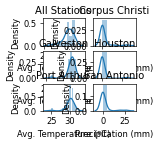

In [102]:
# generate distribution plots then save image according to assignmen specs
fig, axes = plt.subplots(3, 2, figsize=(2, 2), dpi=60)

myFunction.generate_density_plot(station_data['TAVG'], axes[0, 0], 'Avg. Temperature (ºC)', 'All Stations')
myFunction.generate_density_plot(cctx_station['PRCP'], axes[0, 1], 'Precipitation (mm)', 'Corpus Christi')
myFunction.generate_density_plot(gltx_station['TAVG'], axes[1, 0], 'Avg. Temperature (ºC)', 'Galveston')
myFunction.generate_density_plot(htx_station['PRCP'], axes[1, 1], 'Precipitation (mm)', 'Houston')
myFunction.generate_density_plot(patx_station['TAVG'], axes[2, 0], 'Avg. Temperature (ºC)', 'Port Arthur')
myFunction.generate_density_plot(satx_station['PRCP'], axes[2, 1], 'Precipitation (mm)', 'San Antonio')

clear_output()
plt.savefig('assign1-locations.png')
plt.show()

This section experimented with creating a 60 dpi figure with 6 plots in 3x2 grid format.

In [103]:
# original precipitation data has lon values in degrees east, which is problematic for programming
# here we convert those lon values to typical west orientation
precip_data['lon'] = ((precip_data['lon'] + 180) % 360) - 180
max_temp_data['lon'] = ((max_temp_data['lon'] + 180) % 360) - 180
min_temp_data['lon'] = ((min_temp_data['lon'] + 180) % 360) - 180

Conversion of longitudinal values to west orientation is crucial for accurate mapping of geospatial features

In [104]:
# function to query location according to lat/lon
def query_coords(dataset, min_lat, max_lat, min_lon, max_lon):
  query_result = dataset[(dataset['lat'] >= min_lat) & (dataset['lat'] <= max_lat) & (dataset['lon'] <= min_lon) & (dataset['lon'] <= max_lon)]
  return query_result

In [105]:
# call function to query precipitatipn data and store to variable in the following order:
# dataset(precip), min lat, max lat, min lon, max lon
grid_precip_data_cctx = query_coords(precip_data, cctx_min_lat, cctx_max_lat, cctx_min_lon, cctx_max_lon)
grid_precip_data_gltx = query_coords(precip_data, gltx_min_lat, gltx_max_lat, gltx_min_lon, gltx_max_lon)
grid_precip_data_htx = query_coords(precip_data, htx_min_lat, htx_max_lat, htx_min_lon, htx_max_lon)
grid_precip_data_patx = query_coords(precip_data, patx_min_lat, patx_max_lat, patx_min_lon, patx_max_lon)
grid_precip_data_satx = query_coords(precip_data, satx_min_lat, satx_max_lat, satx_min_lon, satx_max_lon)

In [106]:
# call function to query temperature data and store to variable in the following order:
# dataset(precip), min lat, max lat, min lon, max lon

max_temp_data_cctx = query_coords(max_temp_data, cctx_min_lat, cctx_max_lat, cctx_min_lon, cctx_max_lon)
max_temp_data_gltx = query_coords(max_temp_data, gltx_min_lat, gltx_max_lat, gltx_min_lon, gltx_max_lon)
max_temp_data_htx = query_coords(max_temp_data, htx_min_lat, htx_max_lat, htx_min_lon, htx_max_lon)
max_temp_data_patx = query_coords(max_temp_data, patx_min_lat, patx_max_lat, patx_min_lon, patx_max_lon)
max_temp_data_satx = query_coords(max_temp_data, satx_min_lat, satx_max_lat, satx_min_lon, satx_max_lon)

min_temp_data_cctx = query_coords(min_temp_data, cctx_min_lat, cctx_max_lat, cctx_min_lon, cctx_max_lon)
min_temp_data_gltx = query_coords(min_temp_data, gltx_min_lat, gltx_max_lat, gltx_min_lon, gltx_max_lon)
min_temp_data_htx = query_coords(min_temp_data, htx_min_lat, htx_max_lat, htx_min_lon, htx_max_lon)
min_temp_data_patx = query_coords(min_temp_data, patx_min_lat, patx_max_lat, patx_min_lon, patx_max_lon)
min_temp_data_satx = query_coords(min_temp_data, satx_min_lat, satx_max_lat, satx_min_lon, satx_max_lon)

In [107]:
# create an interactive map showing the precipitation data
import plotly.express as px
fig = px.scatter_geo(precip_data, lat='lat', lon='lon', color='precip', hover_name='time', projection='orthographic')
fig.update_layout(title='Precipitation Data - Use Mouse to Navigate', geo=dict(showframe=True, showlakes=True, lakecolor='rgb(85,173,240)'), height=600, width=800)
fig.show()

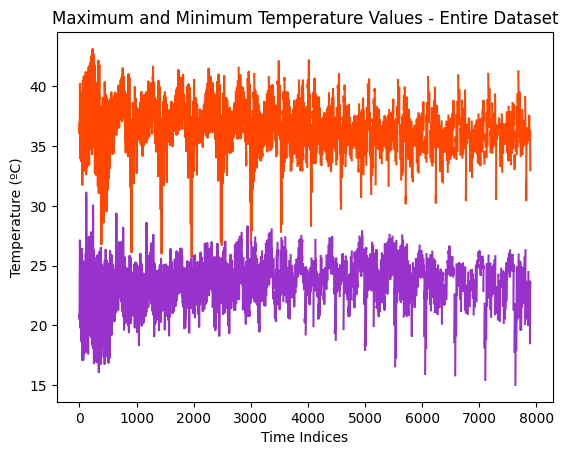

In [108]:
# maximum and minimum temperature for entire dataset
plt.plot(max_temp_data['tmax'], color='orangered')
plt.plot(min_temp_data['tmin'], color='darkorchid')
plt.title('Maximum and Minimum Temperature Values - Entire Dataset')
plt.xlabel('Time Indices')
plt.ylabel('Temperature (ºC)')
plt.show()

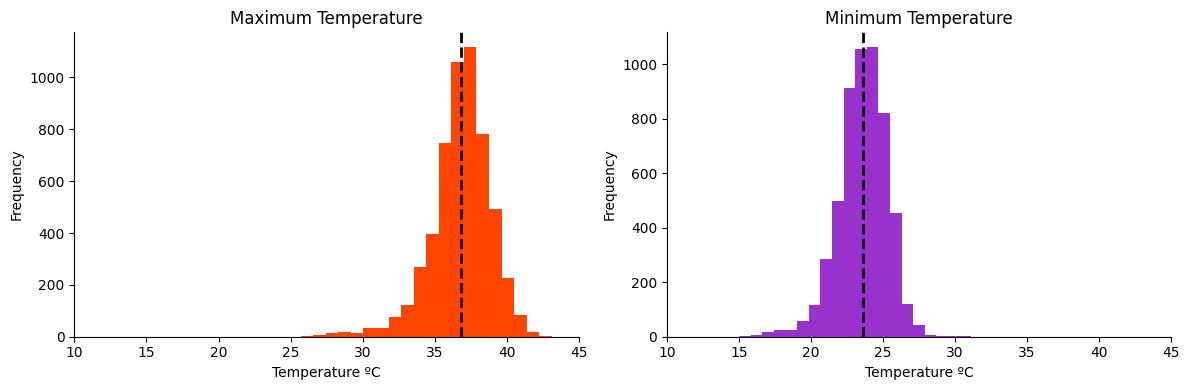

In [109]:
# histograms showing the frequency distribution of
# maximum and minimum temperature
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
hist_x_lim = (10, 45)

mean_value1 = max_temp_data['tmax'].mean()
max_temp_data['tmax'].plot(kind='hist', bins=20, ax=axs[0], color='orangered')
axs[0].set_title('Maximum Temperature')
axs[0].spines[['top', 'right']].set_visible(False)
axs[0].set_xlabel('Temperature ºC')
axs[0].set_ylabel('Frequency')
axs[0].axvline(mean_value1, color='black', linestyle='dashed', linewidth=2, label='Mean')
axs[0].set_xlim(hist_x_lim)

mean_value2 = min_temp_data['tmin'].mean()
min_temp_data['tmin'].plot(kind='hist', bins=20, ax=axs[1], color='darkorchid')
axs[1].set_title('Minimum Temperature')
axs[1].spines[['top', 'right']].set_visible(False)
axs[1].set_xlabel('Temperature ºC')
axs[1].set_ylabel('Frequency')
axs[1].axvline(mean_value2, color='black', linestyle='dashed', linewidth=2, label='Mean')
axs[1].set_xlim(hist_x_lim)

plt.tight_layout()

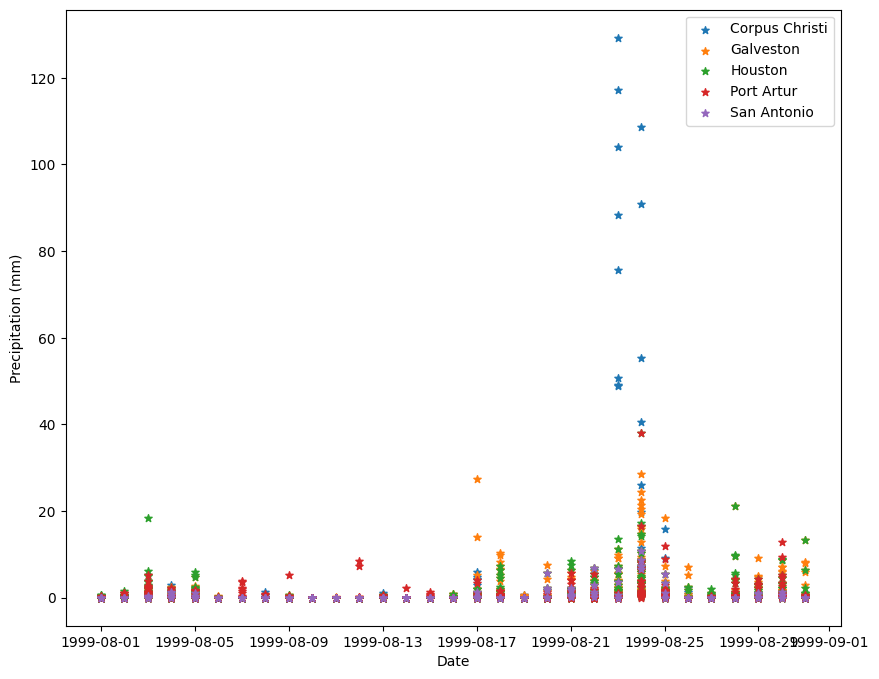

In [110]:
# Set the figure size
plt.figure(figsize=(10, 8))

# Scatter plot for the first variable
plt.scatter(grid_precip_data_cctx['time'], grid_precip_data_cctx['precip'], marker='*', label='Corpus Christi', s=30)
plt.scatter(grid_precip_data_gltx['time'], grid_precip_data_gltx['precip'], marker='*', label='Galveston', s=30)
plt.scatter(grid_precip_data_htx['time'], grid_precip_data_htx['precip'], marker='*', label='Houston', s=30)
plt.scatter(grid_precip_data_patx['time'], grid_precip_data_patx['precip'], marker='*', label='Port Artur', s=30)
plt.scatter(grid_precip_data_satx['time'], grid_precip_data_satx['precip'], marker='*',label='San Antonio', s=30)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
clear_output()
plt.show()

**Plot Grids**

In [111]:
# grids easier to plot with xarray structure, so reserve it back
precip_xr = xr.open_mfdataset('/content/data-analytics/precip_aug_1999.nc4')
max_temp_xr = xr.open_mfdataset('/content/data-analytics/tmax.1999.nc.nc4')
min_temp_xr = xr.open_mfdataset('/content/data-analytics/tmin.1999.nc.nc4')

In [112]:
precip_xr_lat, precip_xr_lon = precip_xr['lat'], precip_xr['lon']
precipitation = precip_xr['precip'][22,:,:]

In [113]:
precip_data

,lon,time,lat,precip
0,-99.875,1999-08-01,25.125,NaN
1,-99.875,1999-08-01,25.375,NaN
2,-99.875,1999-08-01,25.625,NaN
3,-99.875,1999-08-01,25.875,NaN
4,-99.875,1999-08-01,26.125,NaN
...,...,...,...,...
29662,-92.875,1999-08-31,32.125,0.0
29663,-92.875,1999-08-31,32.375,0.0
29664,-92.875,1999-08-31,32.625,0.0
29665,-92.875,1999-08-31,32.875,0.0


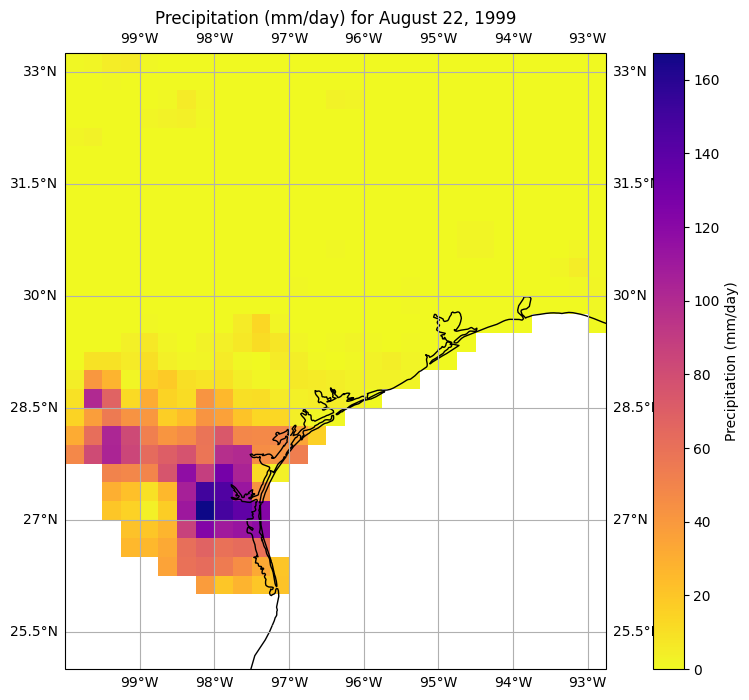

In [114]:
# create a map projection
map_proj = ccrs.PlateCarree()

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.scatter(x=[coord[1] for coord in coords], y=[coord[0] for coord in coords], transform=ccrs.PlateCarree()) # point data

# Plot the precipitation data
ax.pcolormesh(precip_xr_lon, precip_xr_lat, precipitation, cmap='GnBu', transform=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)

# Add a colorbar
colorbar = plt.colorbar(ax.pcolormesh(precip_xr_lon, precip_xr_lat, precipitation[:], cmap='plasma_r', transform=ccrs.PlateCarree()))
colorbar.set_label('Precipitation (mm/day)')

# Set the title and show the plot
plt.title('Precipitation (mm/day) for August 22, 1999')
plt.show()

In [115]:
max_temp_xr_lat, min_temp_xr_lat = max_temp_xr['lat'], min_temp_xr['lat']
max_temp_xr_lon, min_temp_xr_lon = max_temp_xr['lon'], min_temp_xr['lon']
max_temp_xr, min_temp_xr = max_temp_xr['tmax'][1, :, :], min_temp_xr['tmin'][1, :, :]

In [116]:
max_temp_xr_lat, min_temp_xr_lat

(<xarray.DataArray 'lat' (lat: 17)>
 array([32.75, 32.25, 31.75, 31.25, 30.75, 30.25, 29.75, 29.25, 28.75, 28.25,
        27.75, 27.25, 26.75, 26.25, 25.75, 25.25, 24.75], dtype=float32)
 Coordinates:
   * lat      (lat) float32 32.75 32.25 31.75 31.25 ... 26.25 25.75 25.25 24.75
 Attributes:
     actual_range:        [ 89.75 -89.75]
     long_name:           Latitude
     units:               degrees_north
     axis:                Y
     standard_name:       latitude
     coordinate_defines:  center,
 <xarray.DataArray 'lat' (lat: 17)>
 array([32.75, 32.25, 31.75, 31.25, 30.75, 30.25, 29.75, 29.25, 28.75, 28.25,
        27.75, 27.25, 26.75, 26.25, 25.75, 25.25, 24.75], dtype=float32)
 Coordinates:
   * lat      (lat) float32 32.75 32.25 31.75 31.25 ... 26.25 25.75 25.25 24.75
 Attributes:
     actual_range:        [ 89.75 -89.75]
     long_name:           Latitude
     units:               degrees_north
     axis:                Y
     standard_name:       latitude
     coordinate_de

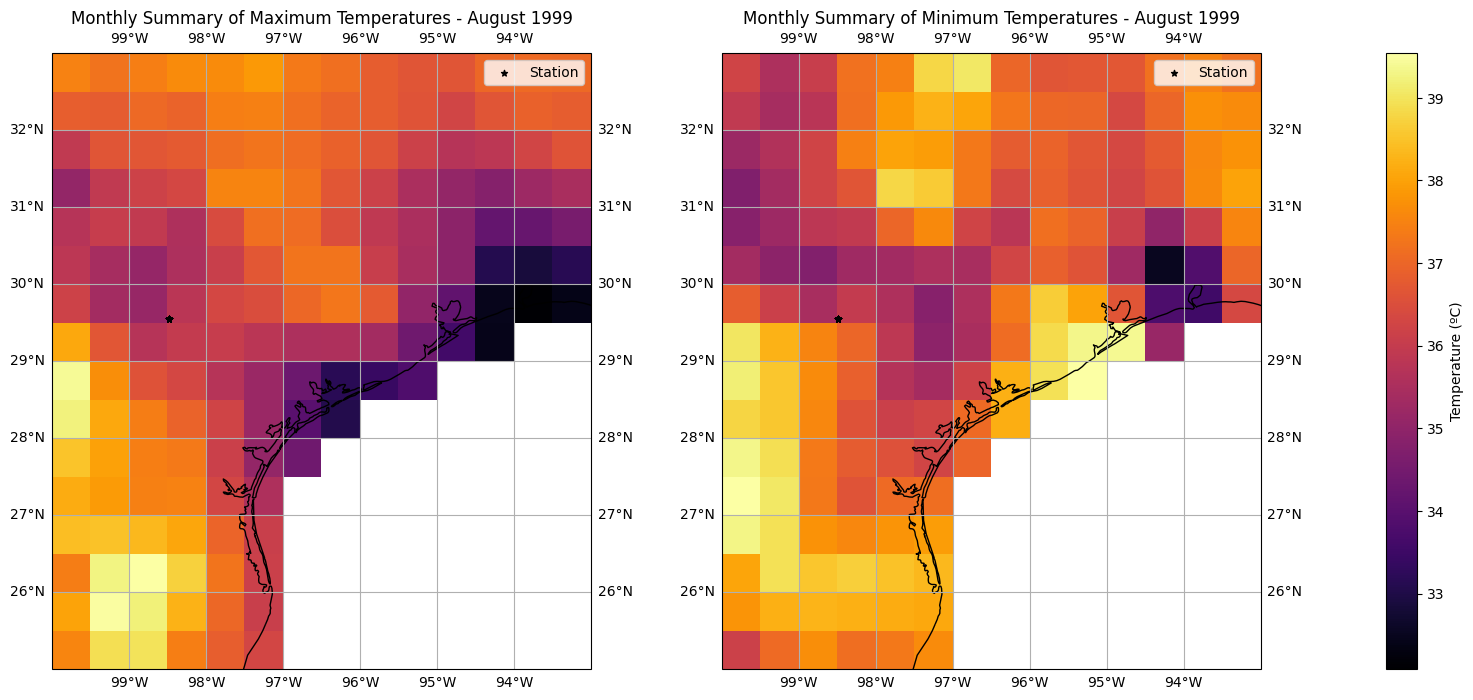

In [117]:
# display gridded and point data in one map
map_proj = ccrs.PlateCarree()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8), subplot_kw={'projection': map_proj})
im1 = myFunction.plot_subplot(ax1, max_temp_xr_lon, max_temp_xr_lat, max_temp_xr, 'inferno', 'Monthly Summary of Maximum Temperatures - August 1999')
im2 = myFunction.plot_subplot(ax2, min_temp_xr_lon, min_temp_xr_lat, min_temp_xr, 'inferno', 'Monthly Summary of Minimum Temperatures - August 1999')
myFunction.create_cbar(im1, [ax1, ax2])

# plot maps and display unique color bar
myFunction.plot_pts(ax1, station_data)
myFunction.plot_pts(ax2, station_data)

Text(0.5, 1.0, 'Relationship between wind speed and peek wind speed')

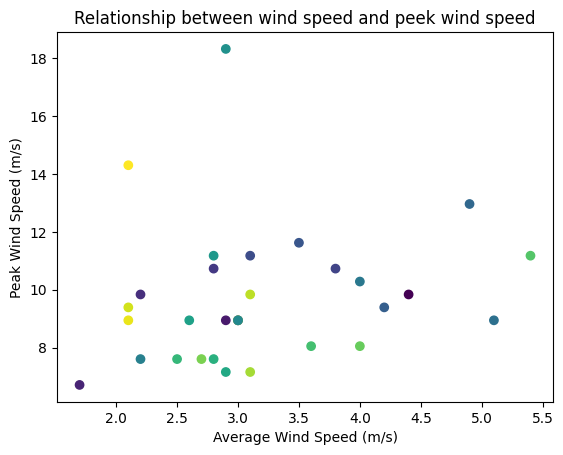

In [118]:
plt.scatter(station_data['AWND'], station_data['PEAK_SPEED'], c=station_data['DATE'], cmap='viridis')
plt.xlabel('Average Wind Speed (m/s)')
plt.ylabel('Peak Wind Speed (m/s)')
plt.title('Relationship between wind speed and peek wind speed')

This was expected but worth plotting to see unexpected occurrences

Text(0.5, 0, 'Wind Speed (m/s)')

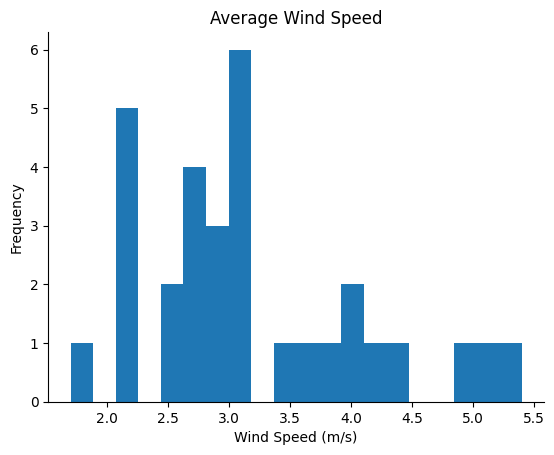

In [119]:
station_data['AWND'].plot(kind='hist', bins=20, title='Average Wind Speed')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Wind Speed (m/s)')

In [120]:
min_temp_data

,lon,time,lat,tmin
0,-99.75,1999-08-01,32.75,20.833620
1,-99.75,1999-08-01,32.25,20.498184
2,-99.75,1999-08-01,31.75,20.498972
3,-99.75,1999-08-01,31.25,21.353714
4,-99.75,1999-08-01,30.75,23.197296
...,...,...,...,...
7900,-92.75,1999-08-31,26.75,NaN
7901,-92.75,1999-08-31,26.25,NaN
7902,-92.75,1999-08-31,25.75,NaN
7903,-92.75,1999-08-31,25.25,NaN
